In [2]:
# Import appropriate libraries
%matplotlib inline
import numpy as np
from datetime import datetime, timedelta
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator,DateFormatter, AutoDateLocator
from metpy.calc.thermo import *
from metpy.units import units

In [3]:
# Request METAR data from TDS 
metar = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml')
dataset = list(metar.datasets.values())[0]
print(list(dataset.access_urls))

['NetcdfSubset']


In [4]:
# Access netcdf subset and use siphon to request data
ncss_url = dataset.access_urls['NetcdfSubset']
ncss = NCSS(ncss_url)
ncss.variables

{'air_pressure_at_sea_level',
 'air_temperature',
 'cloud_area_fraction',
 'dew_point_temperature',
 'hectoPascal_ALTIM',
 'high_cloud_area_fraction',
 'high_cloud_base_altitude',
 'inches_ALTIM',
 'low_cloud_area_fraction',
 'low_cloud_base_altitude',
 'middle_cloud_area_fraction',
 'middle_cloud_base_altitude',
 'numChildren',
 'precipitation_amount_24',
 'precipitation_amount_hourly',
 'report',
 'report_id',
 'report_length',
 'snowfall_amount',
 'snowfall_amount_last_hour',
 'visibility_in_air',
 'visibility_in_air_direction',
 'visibility_in_air_surface',
 'visibility_in_air_vertical',
 'weather',
 'wind_from_direction',
 'wind_from_direction_max',
 'wind_from_direction_min',
 'wind_gust',
 'wind_peak_from_direction',
 'wind_peak_speed',
 'wind_peak_time',
 'wind_speed',
 'xfields'}

In [5]:
# get current date and time
now = datetime.utcnow()
now = datetime(now.year, now.month, now.day, now.hour)

# define time range you want the data for
start = now - timedelta(days=1)
end = now

# build the query
query = ncss.query()
query.lonlat_point(-90.08, 32.32)
query.time_range(start, end)
query.variables('air_temperature', 'dew_point_temperature', 'wind_speed', 
               'precipitation_amount_hourly', 'inches_ALTIM', 
               'air_pressure_at_sea_level')
query.accept('netcdf')

var=wind_speed&var=air_temperature&var=dew_point_temperature&var=air_pressure_at_sea_level&var=inches_ALTIM&var=precipitation_amount_hourly&time_end=2016-07-15T16%3A00%3A00&time_start=2016-07-14T16%3A00%3A00&latitude=32.32&longitude=-90.08&accept=netcdf

In [6]:
# Get the netcdf dataset
data = ncss.get_data(query)
print(list(data.variables))

['latitude', 'longitude', 'stationAltitude', 'station_id', 'station_description', 'wmo_id', 'time', 'stationIndex', 'wind_speed', 'air_temperature', 'dew_point_temperature', 'inches_ALTIM', 'air_pressure_at_sea_level', 'precipitation_amount_hourly']


In [7]:
# Get the station ID
station_id = data['station_id'][:].tostring()
station_id = station_id.decode('utf-8')
print(station_id)

# Get time into a datetime object
time = [datetime.fromtimestamp(t) for t in data['time']]
time

JAN


[datetime.datetime(2016, 7, 14, 17, 0),
 datetime.datetime(2016, 7, 14, 16, 0),
 datetime.datetime(2016, 7, 14, 14, 0),
 datetime.datetime(2016, 7, 14, 13, 0),
 datetime.datetime(2016, 7, 14, 12, 0),
 datetime.datetime(2016, 7, 14, 10, 0),
 datetime.datetime(2016, 7, 15, 9, 54),
 datetime.datetime(2016, 7, 15, 9, 24),
 datetime.datetime(2016, 7, 15, 8, 54),
 datetime.datetime(2016, 7, 15, 7, 54),
 datetime.datetime(2016, 7, 15, 7, 26),
 datetime.datetime(2016, 7, 15, 6, 54),
 datetime.datetime(2016, 7, 15, 6, 46),
 datetime.datetime(2016, 7, 15, 6, 23),
 datetime.datetime(2016, 7, 15, 5, 54),
 datetime.datetime(2016, 7, 15, 5, 26),
 datetime.datetime(2016, 7, 15, 5, 26),
 datetime.datetime(2016, 7, 15, 4, 54),
 datetime.datetime(2016, 7, 15, 4, 35),
 datetime.datetime(2016, 7, 15, 4, 27),
 datetime.datetime(2016, 7, 15, 4, 15),
 datetime.datetime(2016, 7, 15, 3, 54),
 datetime.datetime(2016, 7, 15, 3, 38),
 datetime.datetime(2016, 7, 15, 3, 15),
 datetime.datetime(2016, 7, 15, 3, 6),
 

In [7]:
dewp = data.variables['dew_point_temperature'][:] * units('degC')
slp = data.variables['inches_ALTIM'][:] * units('inHg')
temp = data.variables['air_temperature'][:] * units('degC')

# Get ambient partial pressure, use to calculate mixing ratio
es = saturation_vapor_pressure(dewp)
mixr = mixing_ratio(es, slp)

# Calculate vapor pressure
vp = vapor_pressure(slp, mixr)

# Calculate saturation vapor pressure
svp = saturation_vapor_pressure(temp)

#Calculate relative humidity as a percentage
rh = (vp / svp) * 100


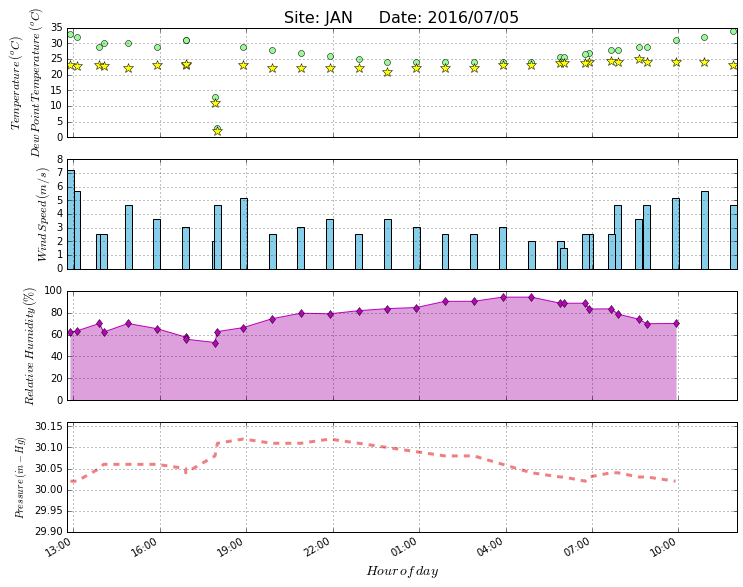

In [8]:
# Create the plots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(12,10))
ax1.plot(time, data['air_temperature'], ls='None', marker='o', color='palegreen')
ax1.plot(time, data['dew_point_temperature'], ls='None', color='yellow', marker='*', ms=10)
ax1.set_ylabel(r'$Temperature\/(^oC)$''\n'r'$Dew\/Point\/Temperature\/(^oC)$', fontsize=12)
ax1.grid(True)

ax2.bar(time, data['wind_speed'], width=.01, align='center', color='skyblue')
ax2.set_ylabel(r'$Wind\/Speed\/(m/s)$', fontsize=12)
ax2.grid(True)

time = sorted(time)
ax3.plot(time, rh, 'md-')
ax3.set_ylabel(r'$Relative\/Humidity\/(\%)$', fontsize=12)
ax3.fill_between(time, 0, rh, color='plum')
ax3.set_ylim(0,100)
ax3.grid(True)

ax4.plot(time, data['inches_ALTIM'], ls='--', color='lightcoral', lw=3)
ax4.set_ylabel(r'$Pressure\/(in-Hg)$')
ax4.set_ylim(29.9,30.16)
ax4.grid(True)

locator = AutoDateLocator()
fmt = DateFormatter('%H:%M')

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(fmt)
ax1.autoscale_view()
ax1.set_title('Site: {}     Date: {}'.format(station_id, time[0].strftime('%Y/%m/%d')), fontsize=16)
ax4.set_xlabel(r'$Hour\/of\/day$', fontsize=14)
fig.autofmt_xdate()
plt.show()